# Exercise 2

Setting up common utils

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

## Question 1

Correlation between trees. This question is about investigating the correlation between decision trees and how this effects an ensemble constructed from them. There are three methods for adding randomisation to the tree growing process:

 1.grow each tree on a bootstrap sample

 2.for each tree select a subset of features at random
 
 3.pick the best random split point

You can use RandomForestClassifier, BaggingClassifier, and ExtraTreesClassifier to achieve various different sets of the above three strategies.

Show how the average amount of correlation between the trees in the ensemble varies as a function of bootstrap yes/no, number of max_features, and picking the best split point at random or not.

Pick one of the classification datasets from http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets.

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#Load data
data=load_breast_cancer()
X = data['data']
y = data['target']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7)

clf = {}

#Build classifier with bootstrapping only
clf['bootstrap'] = {}
clf['bootstrap'] = RandomForestClassifier(n_estimators=100, max_depth=3, max_features=None)
clf['bootstrap'].fit(Xtrain,ytrain)

#Build classifier with random subset of features only
clf['randomfeatures'] = {}
clf['randomfeatures'] = RandomForestClassifier(n_estimators=100, max_depth=3, bootstrap=False)
clf['randomfeatures'].fit(Xtrain,ytrain)

#Build classifier with split point at random only
clf['randomsplit'] = {}
clf['randomsplit'] = ExtraTreesClassifier(n_estimators=100, max_depth=3, max_features=None)
clf['randomsplit'].fit(Xtrain,ytrain)

#Build random forest classifier (bootstrapping + random subset of features)
clf['bootstrap_randomfeatures'] = {} 
clf['bootstrap_randomfeatures'] = RandomForestClassifier(n_estimators=100, max_depth=3)
clf['bootstrap_randomfeatures'].fit(Xtrain,ytrain)

#Build extra trees classifier (random subset of features + split point at random)
clf['randomfeatures_randomsplit'] = {}
clf['randomfeatures_randomsplit'] = ExtraTreesClassifier(n_estimators=100, max_depth=3)
clf['randomfeatures_randomsplit'].fit(Xtrain,ytrain)

#Build classifier with bootstrapping + split point at random
clf['bootstrap_randomsplit'] = {}
clf['bootstrap_randomsplit'] = BaggingClassifier(base_estimator=DecisionTreeClassifier(splitter='random'),
                                                 n_estimators=100)
clf['bootstrap_randomsplit'].fit(Xtrain,ytrain)

#Build classifier with bootstrapping + random subset of features + split point at random
clf['bootstrap_randomfeatures_randomsplit'] = {}
clf['bootstrap_randomfeatures_randomsplit'] = ExtraTreesClassifier(n_estimators=100, max_depth=3, bootstrap=True)
clf['bootstrap_randomfeatures_randomsplit'].fit(Xtrain,ytrain);

Create function to compute average correlation among decision of all trees for a given classifier.

In [3]:
from scipy.stats.stats import pearsonr

def correlation_trees(clf, X):
    c = []
    for x1 in range(0, clf.estimators_.__len__()-1):
        for x2 in range(x1+1, clf.estimators_.__len__()):
            c.append( pearsonr(clf.estimators_[x1].predict(X), clf.estimators_[x2].predict(X) ) )
    return np.average( c )

Compare average correlation for all classifiers trained before.

In [4]:
for cl in clf.keys():
    corr = correlation_trees( clf[cl], Xtest )
    print('Average correlation for %s is %f' % (cl,corr) )

Average correlation for randomfeatures is 0.426732
Average correlation for bootstrap is 0.435082
Average correlation for bootstrap_randomfeatures is 0.418903
Average correlation for bootstrap_randomsplit is 0.414826
Average correlation for randomfeatures_randomsplit is 0.339384
Average correlation for bootstrap_randomfeatures_randomsplit is 0.319248
Average correlation for randomsplit is 0.414431


The lowest correlation is obtained when random subset of features and random splitting methods are used (aka extra trees).

Now study correlation as a function of the maximum number of features picked up randomly.

/Users/Vincenzo/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/Vincenzo/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


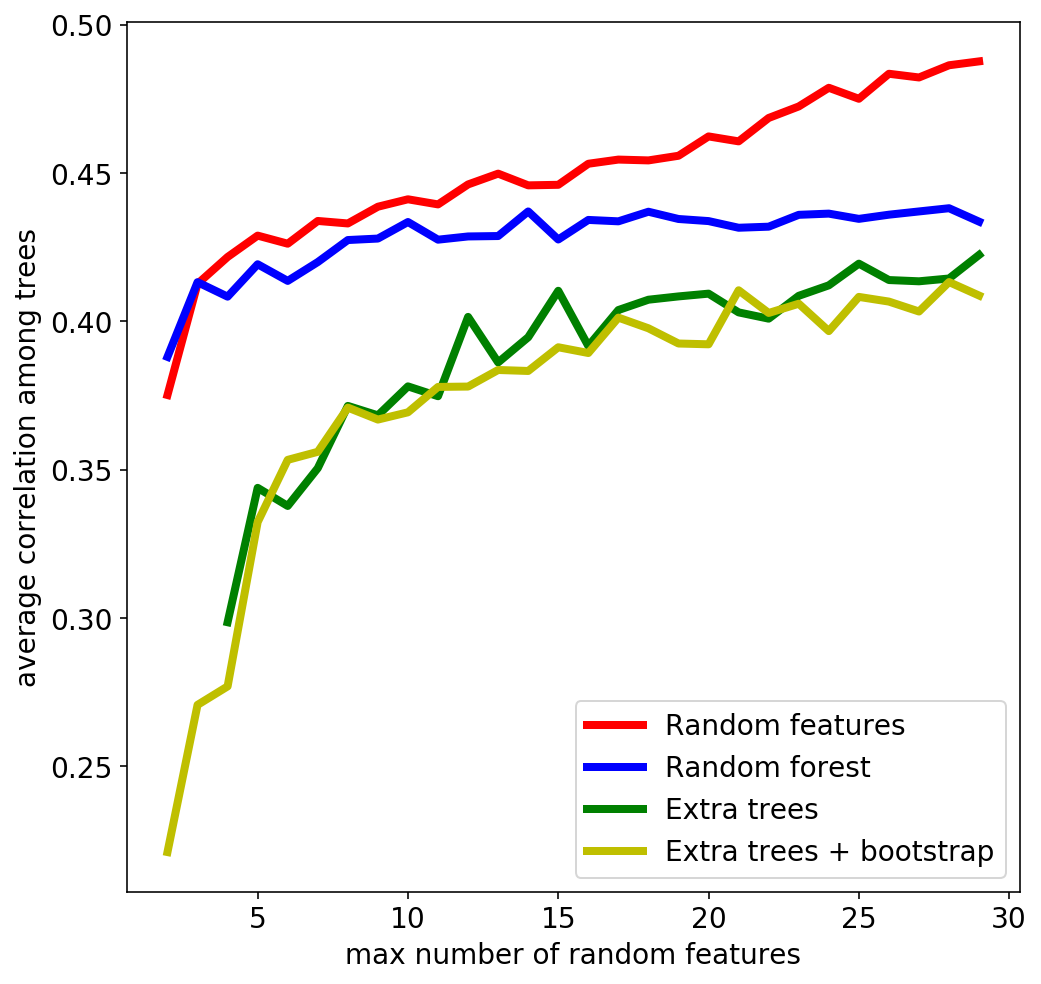

In [5]:
corrs = { 'randomfeatures' : [],
          'bootstrap_randomfeatures' : [],
          'randomfeatures_randomsplit' : [],
          'bootstrap_randomfeatures_randomsplit' : []
         }
max_feat = np.arange(2, data['feature_names'].__len__(), 1)

for max in max_feat:
    clf = {
    'randomfeatures' : RandomForestClassifier(n_estimators=50, max_depth=3, bootstrap=False, max_features=max),
    'bootstrap_randomfeatures' : RandomForestClassifier(n_estimators=50, max_depth=3, max_features=max),
    'randomfeatures_randomsplit' : ExtraTreesClassifier(n_estimators=50, max_depth=3, max_features=max),
    'bootstrap_randomfeatures_randomsplit' : ExtraTreesClassifier(n_estimators=50, max_depth=3, bootstrap=True, 
                                                                      max_features=max)
        }
    
    clf['randomfeatures'].fit(Xtrain,ytrain)
    clf['bootstrap_randomfeatures'].fit(Xtrain,ytrain)
    clf['randomfeatures_randomsplit'].fit(Xtrain,ytrain)
    clf['bootstrap_randomfeatures_randomsplit'].fit(Xtrain,ytrain)
    
    corrs['randomfeatures'].append( correlation_trees(clf['randomfeatures'], Xtest) )
    corrs['bootstrap_randomfeatures'].append( correlation_trees(clf['bootstrap_randomfeatures'], Xtest) )
    corrs['randomfeatures_randomsplit'].append( correlation_trees(clf['randomfeatures_randomsplit'], Xtest) )
    corrs['bootstrap_randomfeatures_randomsplit'].append( correlation_trees(clf['bootstrap_randomfeatures_randomsplit'], Xtest) )

plt.plot(max_feat, corrs['randomfeatures'], label='Random features', c='r', lw=4)
plt.plot(max_feat, corrs['bootstrap_randomfeatures'], label='Random forest', c='b', lw=4)
plt.plot(max_feat, corrs['randomfeatures_randomsplit'], label='Extra trees', c='g', lw=4)
plt.plot(max_feat, corrs['bootstrap_randomfeatures_randomsplit'], label='Extra trees + bootstrap', c='y', lw=4)
plt.xlabel('max number of random features')
plt.ylabel('average correlation among trees')
plt.legend(loc='best');

The correlation increases when the number of features in increased.

## Question 2

Compare the feature importances calculated by a RandomForestClassifier, ExtraTreesClassifier and GradientBoostedTreesClassifier on the digits dataset. You might have to tune n_estimators to get good performance. Which parts of the images is the most important and do you agree with the interpretation of the classifiers? (Bonus) Do the importances change if you change to problem to be a classification problem of odd vs even digit?
You can load the data set with: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

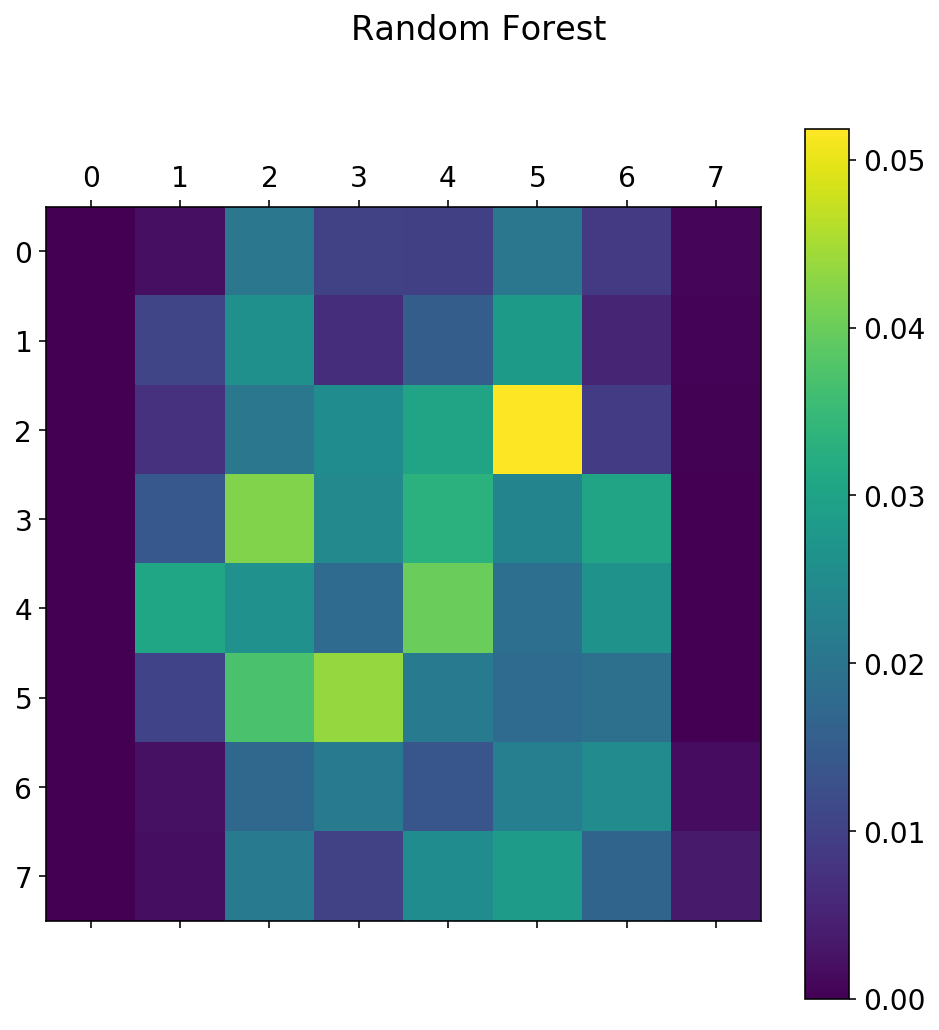

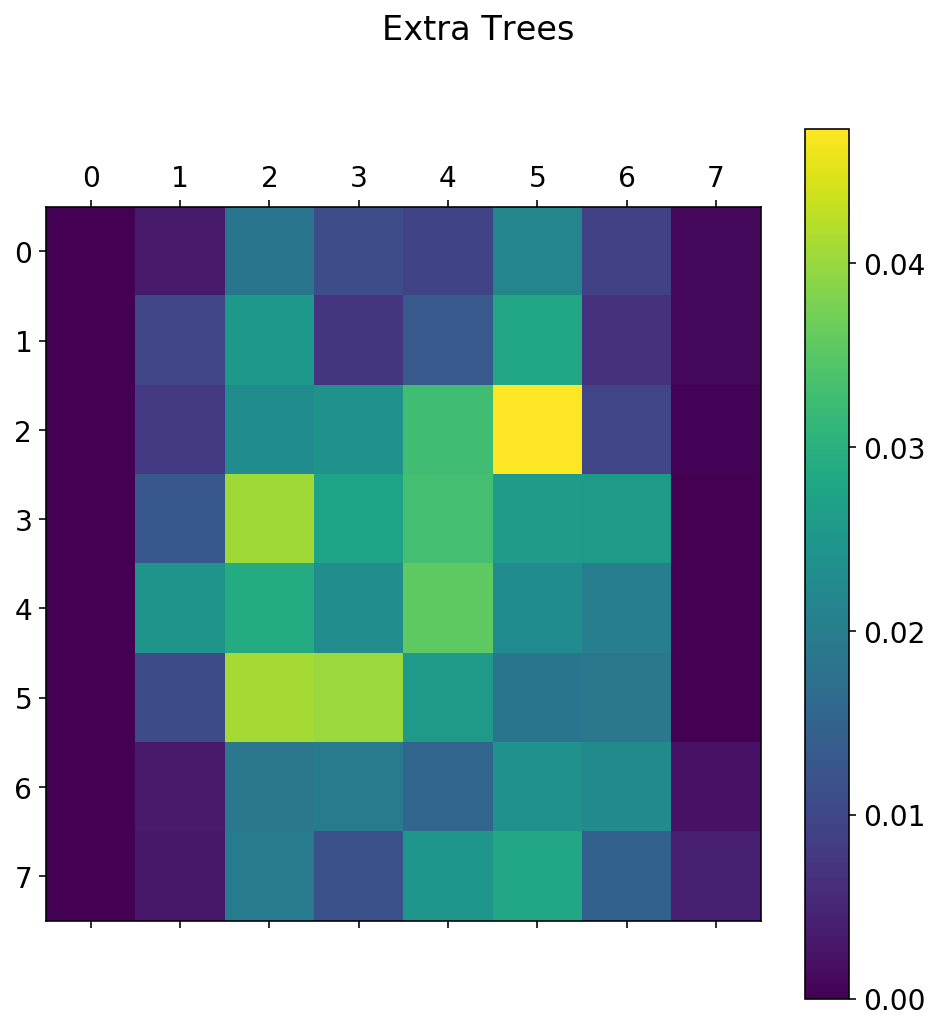

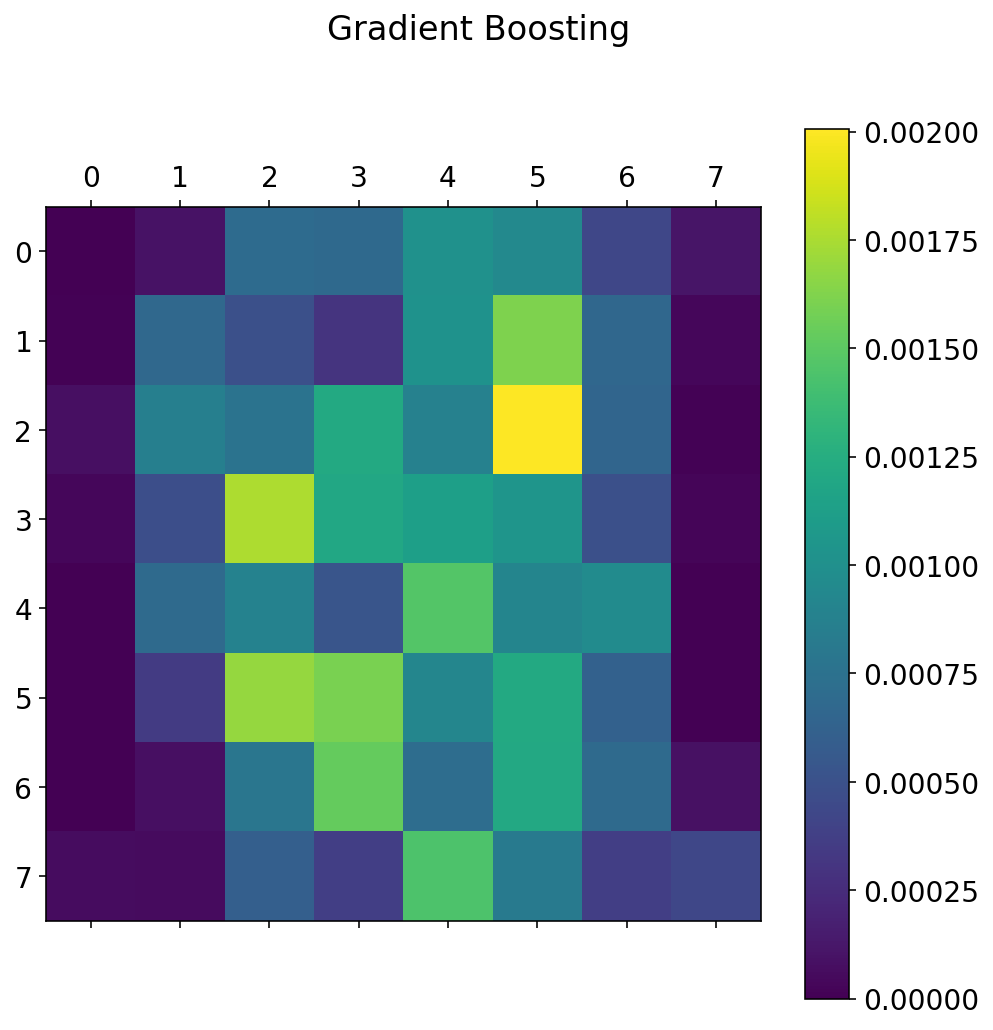

In [6]:
#Load data
from sklearn.datasets import load_digits
from sklearn.ensemble import GradientBoostingClassifier
import math

data = load_digits()
data
X = data['data']
y = data['target']

#Create classifiers
clf_rfc = RandomForestClassifier(n_estimators=3000)
clf_rfc.fit(X, y)

clf_etc = ExtraTreesClassifier(n_estimators=3000)
clf_etc.fit(X, y)

clf_gbc = GradientBoostingClassifier(n_estimators=3000)
clf_gbc.fit(X, y)

#Compare feature importance
dim = int(math.sqrt(data['data'].shape[1]))

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
cax1 = ax1.matshow(np.array(clf_rfc.feature_importances_).reshape((dim,dim)), interpolation='nearest' )
fig1.colorbar(cax1)
plt.suptitle('Random Forest')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
cax2 = ax2.matshow(np.array(clf_etc.feature_importances_).reshape((dim,dim)), interpolation='nearest' )
fig2.colorbar(cax2)
plt.suptitle('Extra Trees')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
cax3 = ax3.matshow(np.array(clf_gbc.feature_importances_).reshape((dim,dim)), interpolation='nearest' )
fig3.colorbar(cax3)
plt.suptitle('Gradient Boosting');

The most important features are the central pixels of the image, whereas the least important ones are the pixels at the boundary. This makes sense since each digit is written approximately in the center of the square.

Now train classifier to distinguish odd vs even digits and check how importance changes.

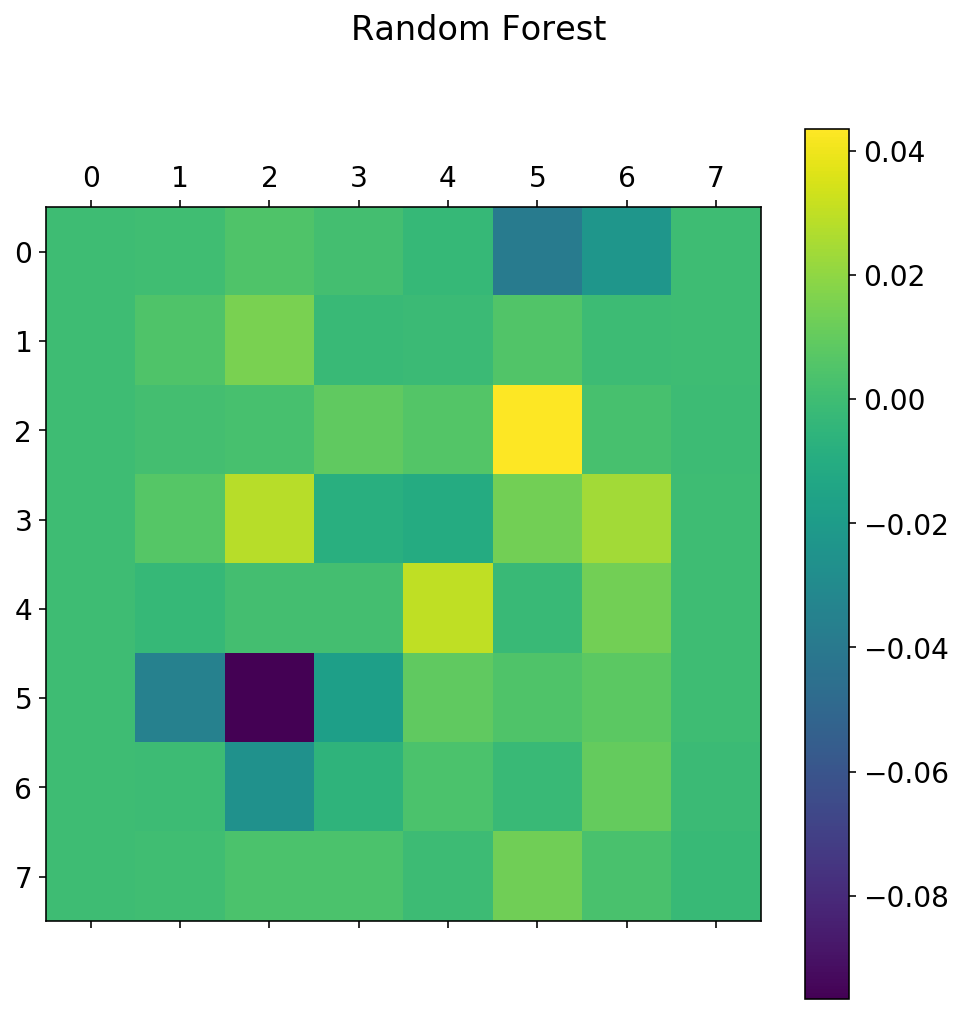

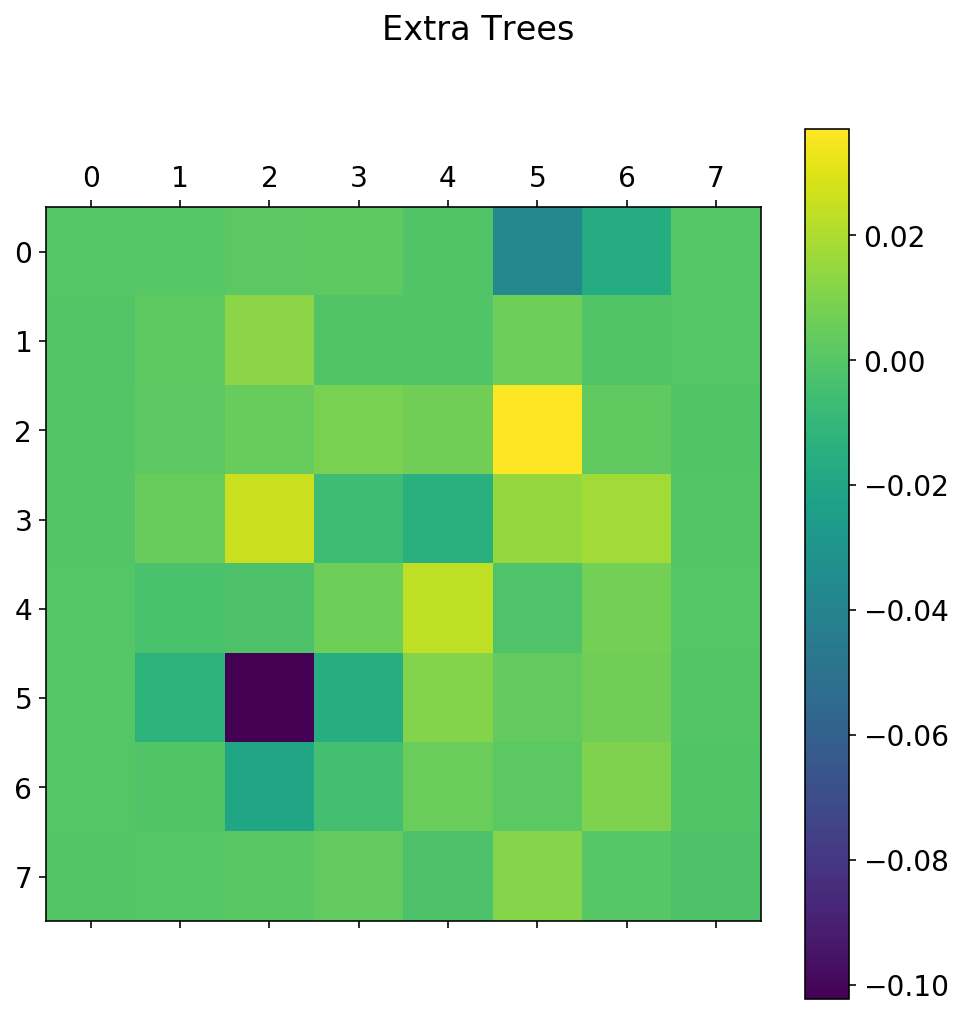

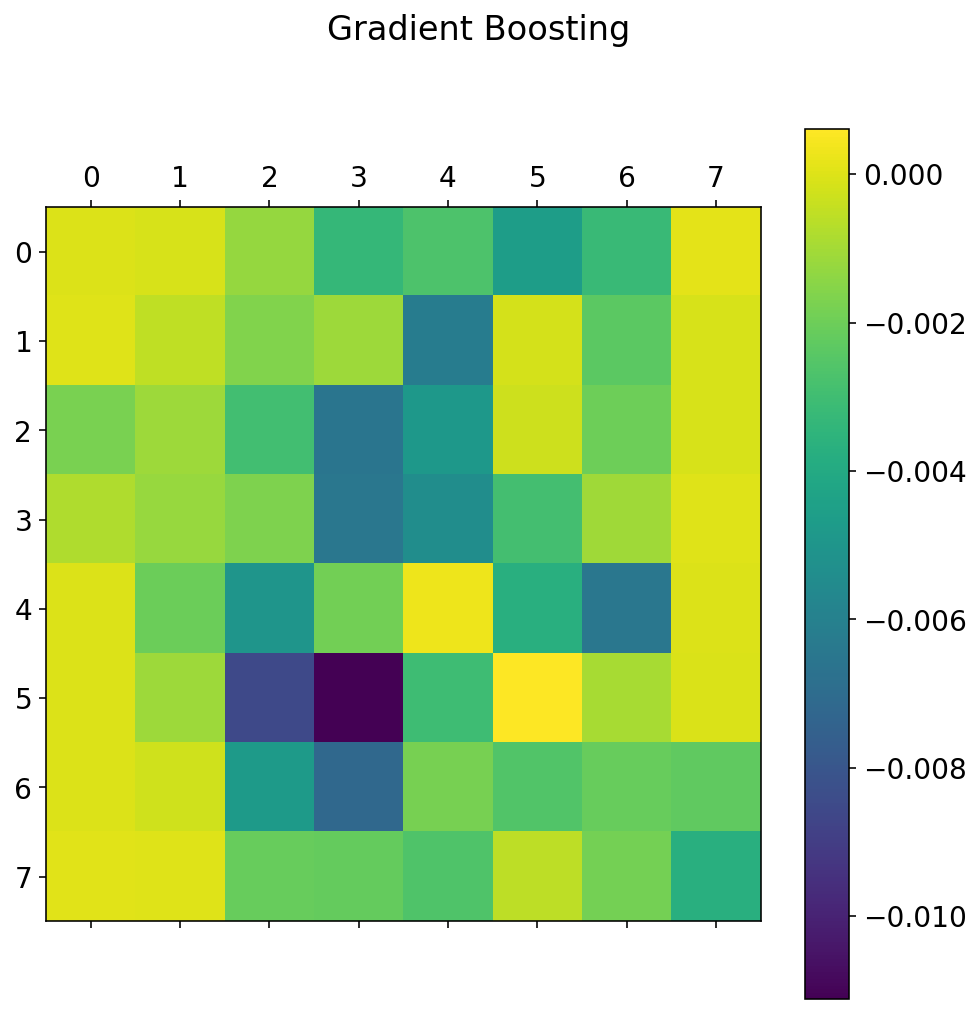

In [7]:
#Redefine target as 0 (odd) or 1 (even)
y = data['target'] % 2 == 0

#Retrain classifiers
clf_rfc_bool = RandomForestClassifier(n_estimators=3000)
clf_rfc_bool.fit(X, y)

clf_etc_bool = ExtraTreesClassifier(n_estimators=3000)
clf_etc_bool.fit(X, y)

clf_gbc_bool = GradientBoostingClassifier(n_estimators=3000)
clf_gbc_bool.fit(X, y)

#Compute and plot difference in importance
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
diff_rfc = clf_rfc.feature_importances_ - clf_rfc_bool.feature_importances_
cax1 = ax1.matshow(np.array(diff_rfc).reshape((dim,dim)), interpolation='nearest' )
fig1.colorbar(cax1)
plt.suptitle('Random Forest')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
diff_etc = clf_etc.feature_importances_ - clf_etc_bool.feature_importances_
cax2 = ax2.matshow(np.array(diff_etc).reshape((dim,dim)), interpolation='nearest' )
fig2.colorbar(cax2)
plt.suptitle('Extra Trees')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
diff_gbc = clf_gbc.feature_importances_ - clf_gbc_bool.feature_importances_
cax3 = ax3.matshow(np.array(diff_gbc).reshape((dim,dim)), interpolation='nearest' )
fig3.colorbar(cax3)
plt.suptitle('Gradient Boosting');

The difference is, on average, centered around zero, except for a bigger difference at the pixel (2,5). 

## Question 3

This is a regression problem. Use a gradient boosted tree regressor (tune the max_depth, learning_rate and n_estimators parameters) to study the importance of the different features as well as the partial dependence of the output on individual features as well as pairs of features.

can you identify uninformative features?

how do the interactions between the features show up in the partial dependence plots?

(Help: rgr = GradientBoostingRegressor(n_estimators=200, max_depth=2, learning_rate=0.1) seems to work quite well) (Help: to produce 1D and 2D partial dependence plots pass [0,1, (0,1)] as the features argument of plot_partial_dependence. More details in the function's documentation.)

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

#Create toy data
def make_data(n_samples=800, n_features=8, noise=0.2, random_state=2):
    generator = check_random_state(random_state)

    X = generator.rand(n_samples, n_features)
    y = 10 * (X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 \
        + 10 * X[:, 3] + 10 * X[:, 4] + noise * generator.randn(n_samples)

    return X, y

X,y = make_data()

#Optimize gradient boosting parameters by using a grid search algorithm
#Fix n_estimators=200 for simplicity
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [1,2,3,4],
              'learning_rate': [0.2, 0.15, 0.1, 0.05, 0.01],
              }
rgr = GradientBoostingRegressor(n_estimators=200)
grid_search = GridSearchCV(rgr, param_grid).fit(X,y)
print(grid_search.best_params_)

{'learning_rate': 0.2, 'max_depth': 2}


Check feature importance.

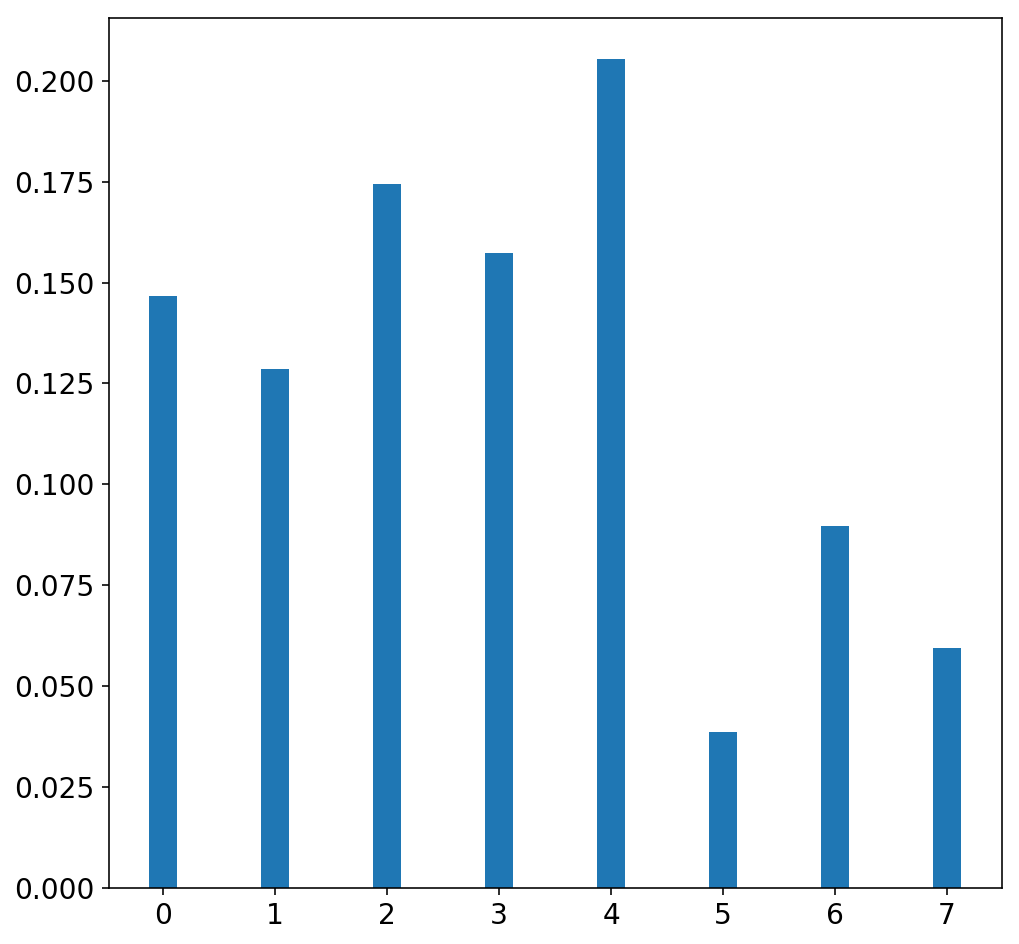

In [14]:
rgr = GradientBoostingRegressor(n_estimators=200, 
                                learning_rate = grid_search.best_params_['learning_rate'],
                                max_depth= grid_search.best_params_['max_depth'])
rgr.fit(X,y)
plt.bar(np.arange(X.shape[1]), rgr.feature_importances_, 0.25, label='Gradient Boosting');

Produce 1D partial dependence plots.

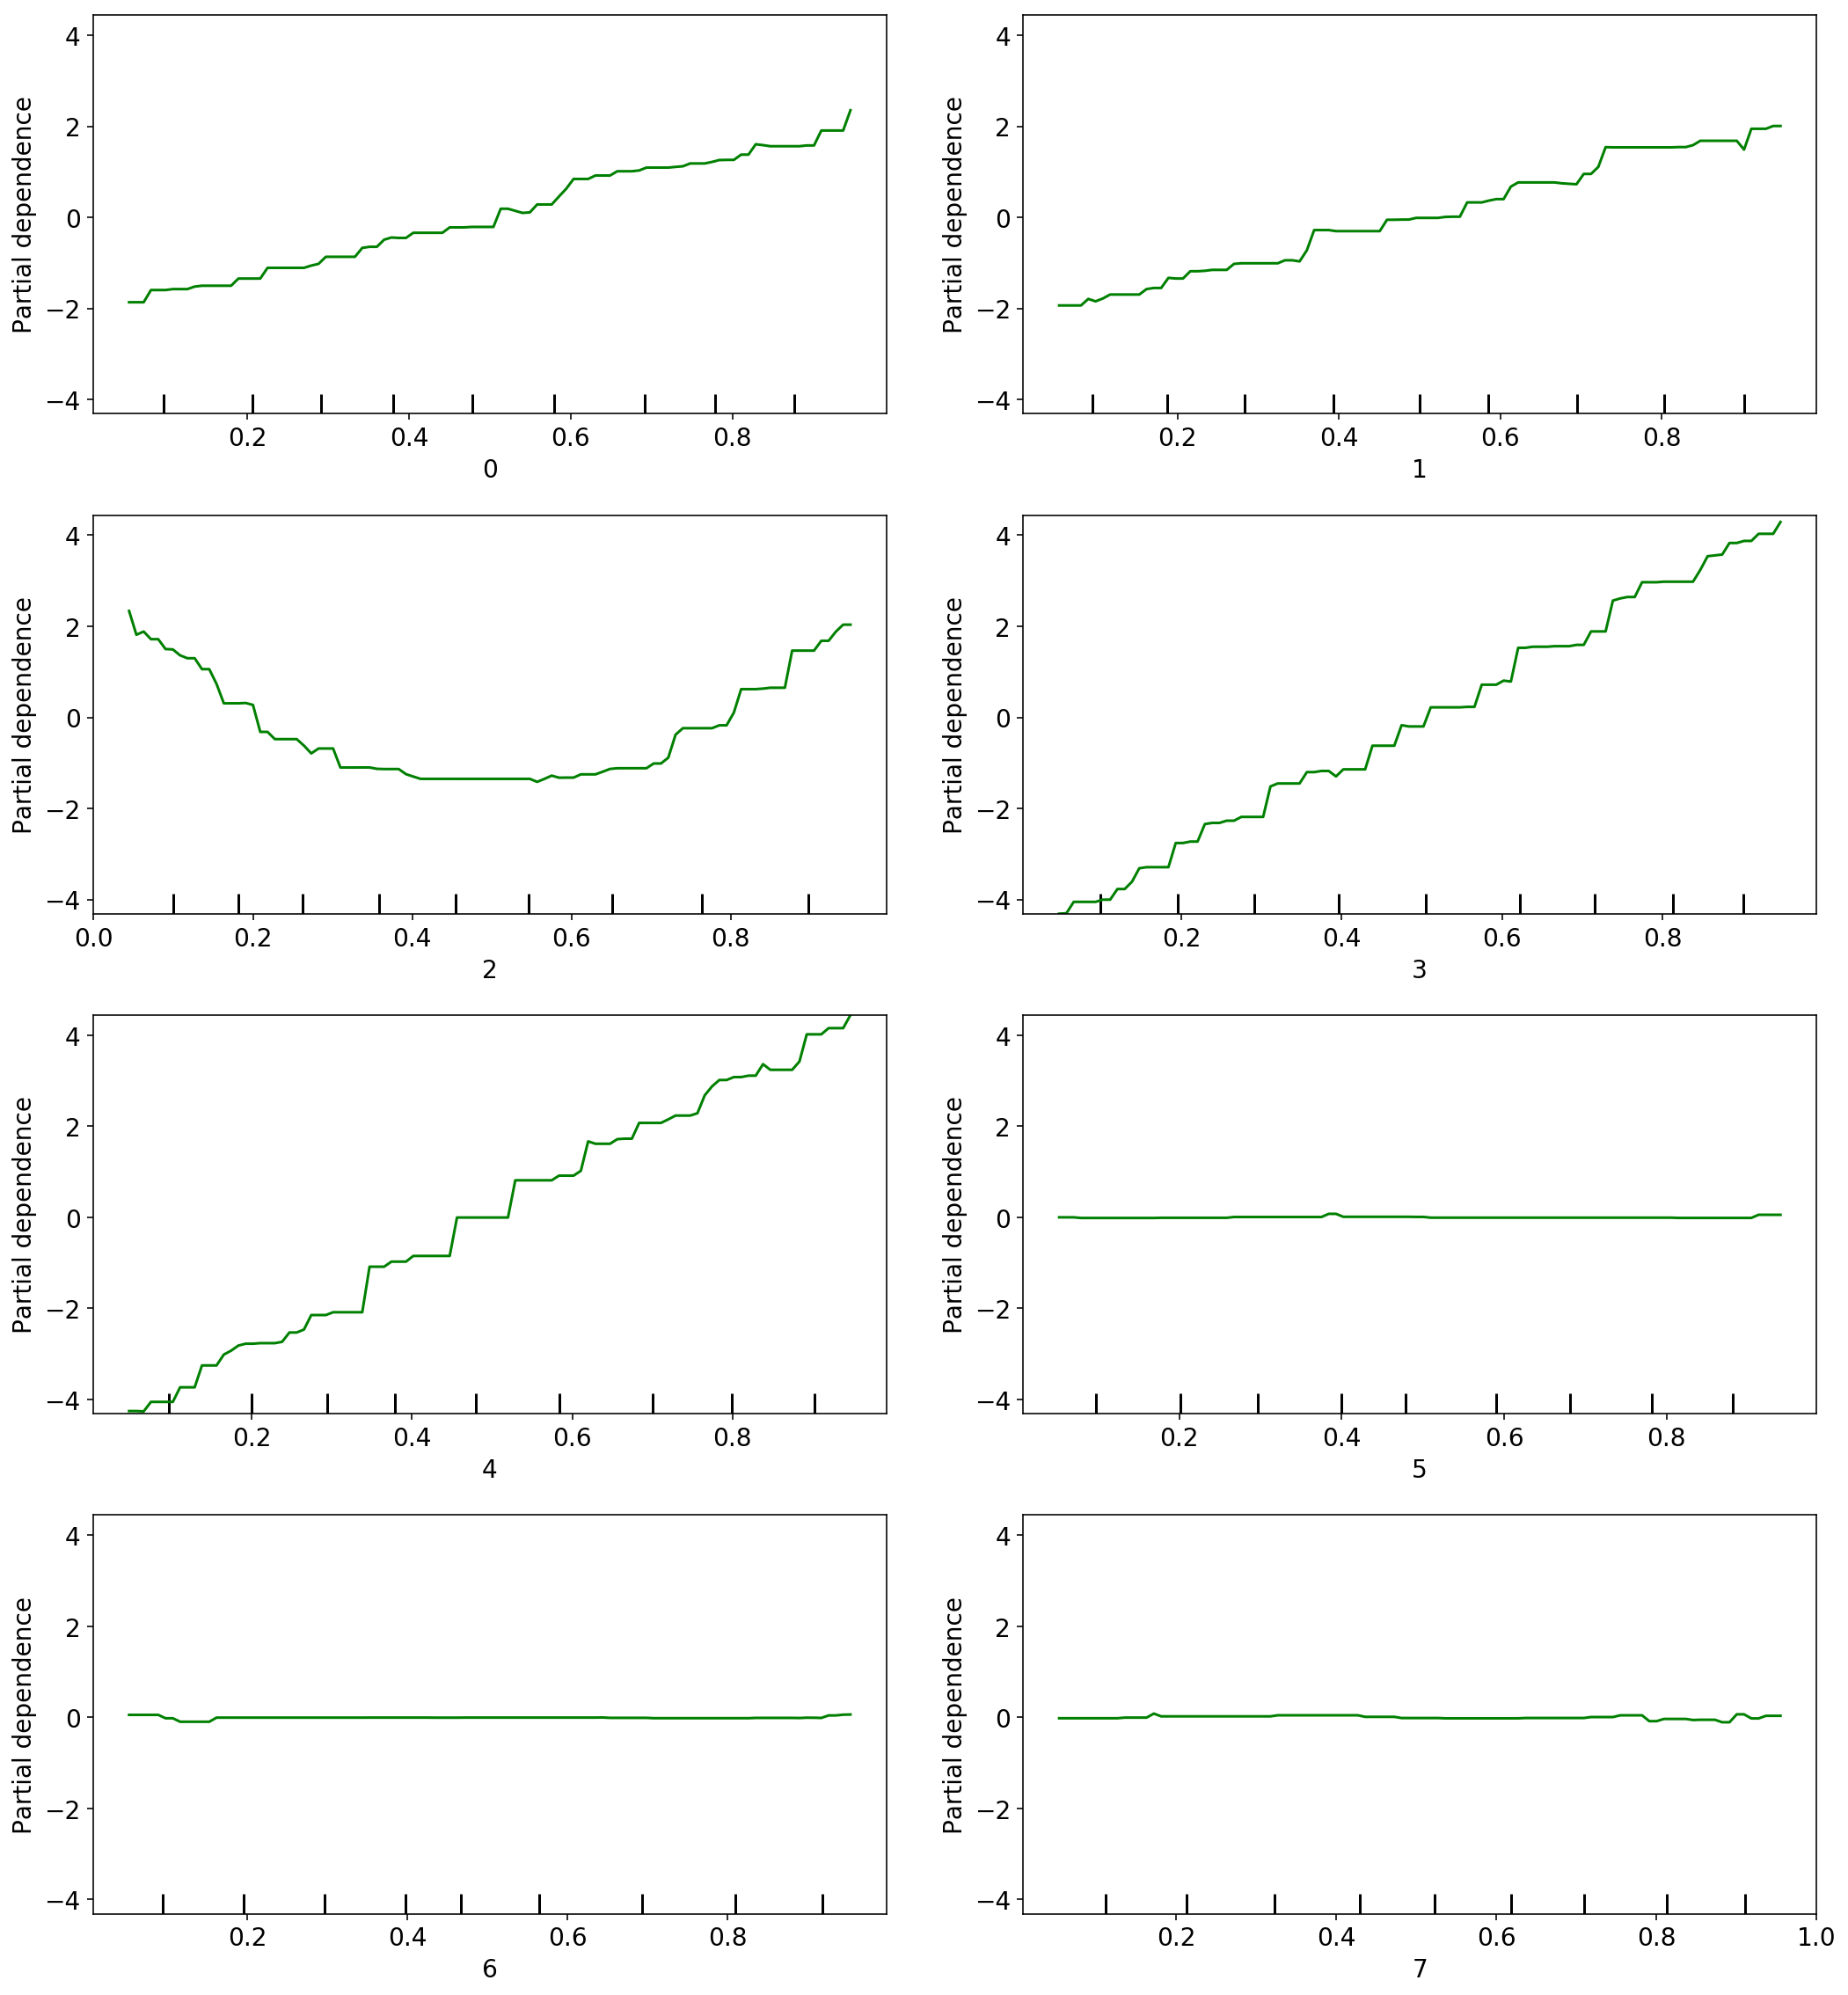

In [16]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

plot_partial_dependence(rgr, X, features=range(X.shape[1]),
                        figsize=(15,16), n_cols=2)
plt.tight_layout();

Produce 2D partial dependence plots.

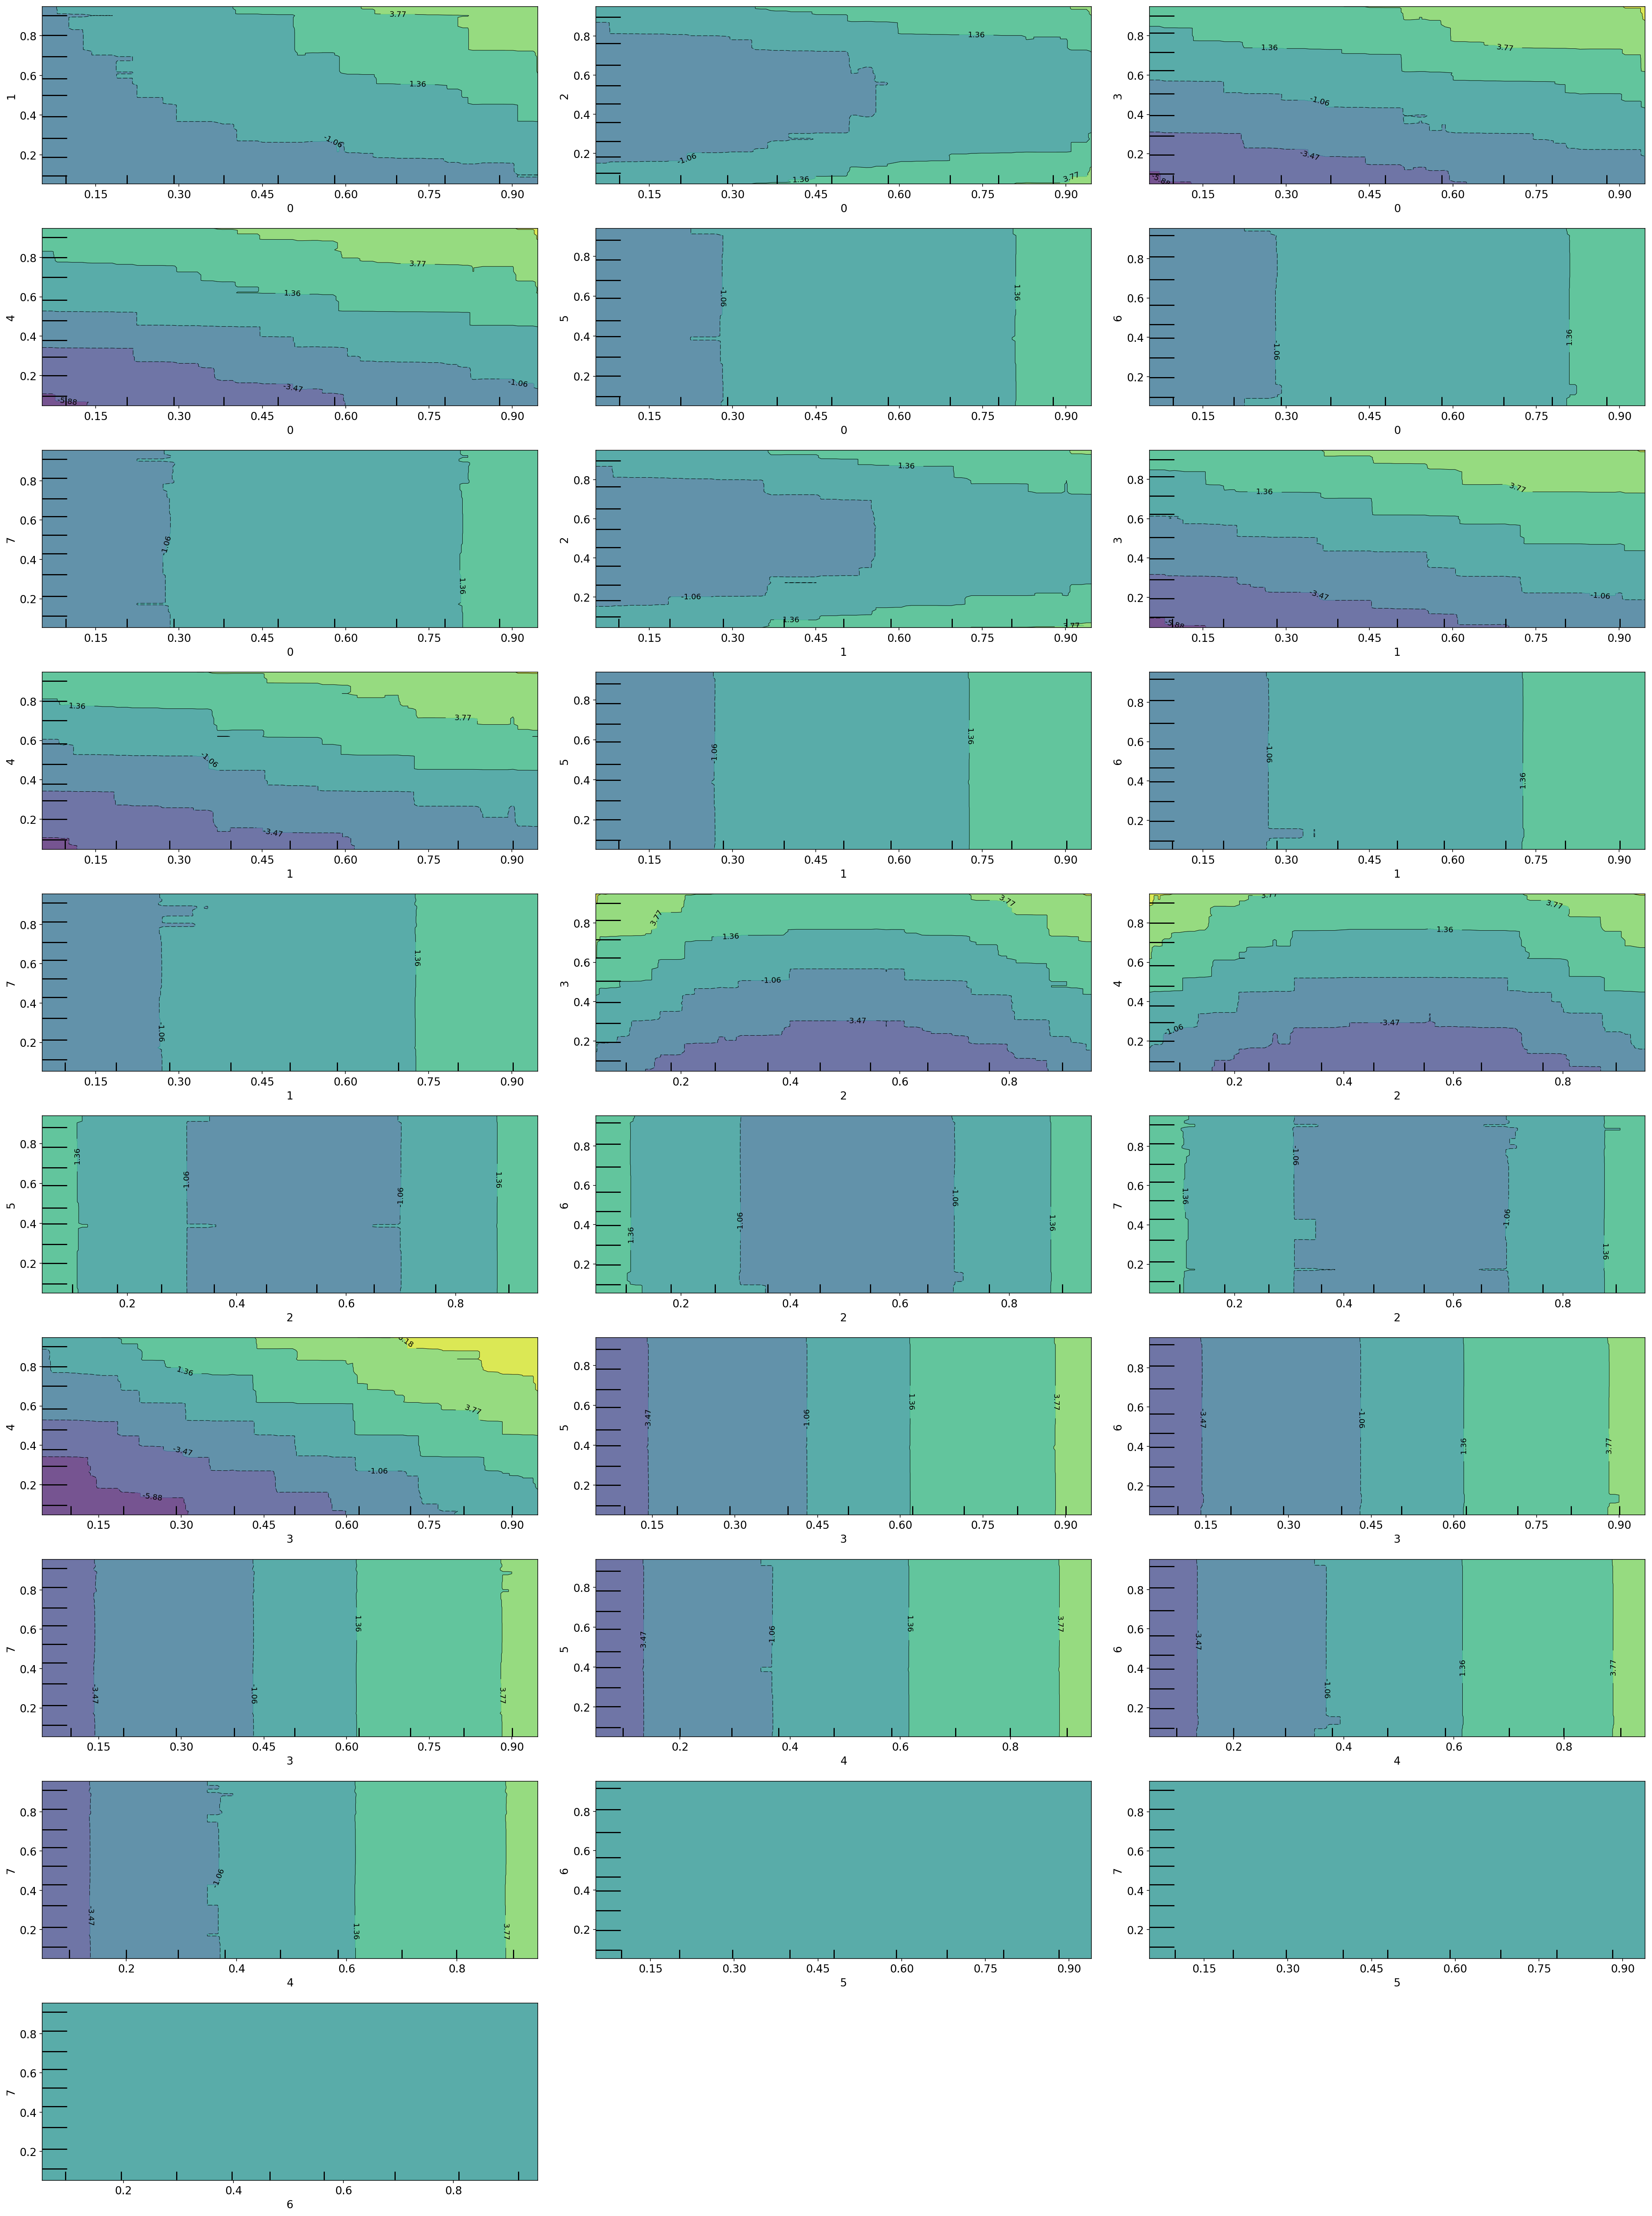

In [23]:
feat = []
for x1 in range(0,X.shape[1]-1):
    for x2 in range(x1+1,X.shape[1]):
         feat.append( (x1,x2) )
        
plot_partial_dependence(rgr, X, 
                        features=feat,
                        figsize=(30,40), n_cols=3);

plt.tight_layout();

Features 5, 6 and 7 are uninformative because the target does not depend at all on their values, as can be seen from the 1D partial dependence plots.

Moreover, the relative importance of 5, 6 and 7 is smaller than the importance of the other values.

From the 2D partial dependence plot, one can see that features 1, 2, 3 and 4 have non-trivial correlations among each other. On the contrary, the partial dependence on uninformative features 5, 6 and 7 is always flat, i.e. the gradient of the partial dependence is always orthogonal to the uninformative dimensions.